In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

In [14]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

In [3]:
spark = SparkSession \
    .builder \
    .appName("Python Spark Decision Tree classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true') \
                .load("../data/WineData2.csv",header=True);
df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [5]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

In [6]:
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

In [7]:
df = df.withColumn("quality", quality_udf("quality"))
df.show(5,True)
df.printSchema()

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chl

In [8]:
#Convert the data into dense vectors
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [9]:
#the same transData functionality can be achieved using the following toDummy method
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):

    '''
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :param labelCol:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com

    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])

    >>> indexCol = 'id'
    >>> categoricalCols = ['category']
    >>> continuousCols = []
    >>> labelCol = []

    >>> mat = get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol)
    >>> mat.show()

    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

In [10]:
#transform the data
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [11]:
#dealing with categorical variables
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(10, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.4,0.66,0.0,1.8...|medium|         0.0|
|[7.9,0.6,0.06,1.6...|medium|         0.0|
|[7.3,0.65,0.0,1.2...|  high|         1.0|
|[7.8,0.58,0.02,2....|  high|         1.0|
|[7.5,0.5,0.36,6.1...|medium|         0.0|
+--------------------+------+------------+
only showing top 10 rows



In [12]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(10, False)

+--------------------------------------------------------+------+--------------------------------------------------------+
|features                                                |label |indexedFeatures                                         |
+--------------------------------------------------------+------+--------------------------------------------------------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |medium|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |medium|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |medium|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|medium|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |medium|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
|[7.4,0.66,0.0,1

In [13]:
#training and test split
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[4.9,0.42,0.0,2.1...|  high|
|[5.0,0.38,0.01,1....|medium|
|[5.0,0.74,0.0,1.2...|medium|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,1.02,0.04,1....|   low|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.47,0.02,1....|medium|
+--------------------+------+
only showing top 5 rows



In [15]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [17]:
#pipeline

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

In [18]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [19]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[5.0,0.4,0.5,4.3,...|medium|           low|
|[5.0,0.42,0.24,2....|  high|          high|
|[5.0,1.02,0.04,1....|   low|        medium|
|[5.0,1.04,0.24,1....|medium|          high|
|[5.1,0.47,0.02,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [20]:
#Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.183254
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_f61fb0a188c7) of depth 5 with 53 nodes


In [21]:
#visualization
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)

In [47]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

In [50]:
cnf_matrix = confusion_matrix(list(y_true["label"].values), list(y_pred["predictedLabel"].values), labels= class_temp)
cnf_matrix

array([[476,  33,  14],
       [ 52,  37,   0],
       [ 17,   0,   4]])

Confusion matrix, without normalization
[[476  33  14]
 [ 52  37   0]
 [ 17   0   4]]


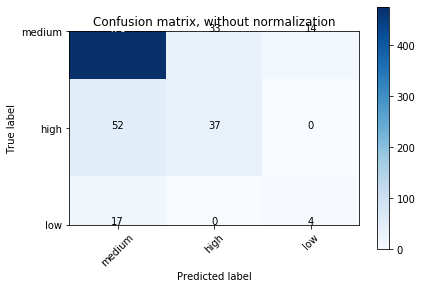

In [54]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.91013384 0.06309751 0.02676864]
 [0.58426966 0.41573034 0.        ]
 [0.80952381 0.         0.19047619]]


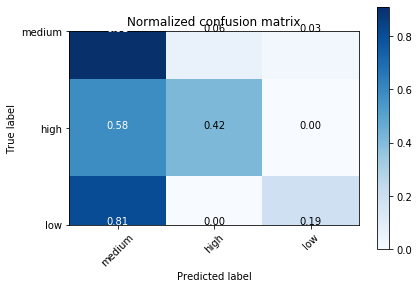

In [56]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()